# Load Dependencies

In [1]:
import os 
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import TextVectorization

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense

from tensorflow.keras.metrics import Precision, Recall

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load and Explore Data

In [ ]:
train_path = os.path.join('toxic-comment-classification','train.csv', 'train.csv')

In [3]:
train_df = pd.read_csv(train_path)

In [4]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train_df.shape

(159571, 8)

In [6]:
train_df.iloc[0]['comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

# Preprocess the Data

In [7]:
X = train_df['comment_text']
y = train_df[train_df.columns[2:]].values

In [8]:
X

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [9]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [10]:
max_features = 20000  # number of words in the vacab,  
max_len = 400  # Sequence length to pad the outputs to.

vectorizer = TextVectorization(max_tokens = max_features, 
                                    output_sequence_length = max_len, 
                                    output_mode = 'int')   # this means that it is going to map every single word to an integer value


In [11]:
vectorizer.adapt(X.values)

In [ ]:
import tensorflow as tf
vectorizer_model = tf.keras.Sequential([vectorizer])
vectorizer_model.save("vectorizer")

In [13]:
vectorized_text = vectorizer(X.values)

In [14]:
vectorized_text

<tf.Tensor: shape=(159571, 400), dtype=int64, numpy=
array([[ 645,   76,    2, ...,    0,    0,    0],
       [   1,   54, 2489, ...,    0,    0,    0],
       [ 425,  441,   70, ...,    0,    0,    0],
       ...,
       [   1, 7392,  383, ...,    0,    0,    0],
       [   5,   12,  534, ...,    0,    0,    0],
       [   5,    8,  130, ...,    0,    0,    0]])>

## Build Data Pipeline

In [15]:
# MCSHBAP => map, cache, shuffle, batch, prefetch
# from_tensor_slices or list_files

dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)  # how large our buffer size needs to be
dataset = dataset.batch(16)  # each batch represented as a series of 16 samples
dataset = dataset.prefetch(8)  # helps prevent bottlenecks

In [16]:
one_batch = dataset.as_numpy_iterator().next()    # batch of 16 training example
one_batch

(array([[  40,   35, 3132, ...,    0,    0,    0],
        [   8,  210,    8, ...,    0,    0,    0],
        [   1, 7021,  160, ...,    0,    0,    0],
        ...,
        [  12, 1709,    8, ...,    0,    0,    0],
        [ 265,    3,   17, ...,    0,    0,    0],
        [  18,  260,   18, ...,    0,    0,    0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [17]:
len(one_batch[0])

16

## Data Splitting

In [18]:
print(f'The dataset contains {len(dataset)} batch')

The dataset contains 9974 batch


In [19]:
train = dataset.take(int(len(dataset)*.9))   # 90%
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.05))   # 5%
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.05))  # 5%

In [20]:
len(train), len(val), len(test)

(8976, 498, 498)

# Modeling

In [21]:
# LSTM
# Long Short-Term Memory layer

## Build the model

In [22]:
model = Sequential()

# Create the embedding layer 
model.add(Embedding(max_features+1, 32))

# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))

# Feature extractor Fully connected layer
model.add(Dense(128, activation='relu'))

# Final layer
model.add(Dense(6, activation='sigmoid'))

In [23]:
model.compile(optimizer='Adam',
              loss='BinaryCrossentropy', 
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          640032    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 665,766
Trainable params: 665,766
Non-trainable params: 0
_________________________________________________________________


## Training

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

hist = model.fit(train, epochs=10, validation_data=val, callbacks=[early_stop])

Epoch 1/10
8976/8976 [==============================] - 286s 31ms/step - loss: 0.0596 - accuracy: 0.9868 - val_loss: 0.0456 - val_accuracy: 0.9931
Epoch 2/10
8976/8976 [==============================] - 184s 20ms/step - loss: 0.0458 - accuracy: 0.9910 - val_loss: 0.0428 - val_accuracy: 0.9880
Epoch 3/10
8976/8976 [==============================] - 179s 20ms/step - loss: 0.0413 - accuracy: 0.9913 - val_loss: 0.0355 - val_accuracy: 0.9950
Epoch 4/10
8976/8976 [==============================] - 180s 20ms/step - loss: 0.0371 - accuracy: 0.9696 - val_loss: 0.0346 - val_accuracy: 0.9940
Epoch 5/10
8976/8976 [==============================] - 179s 20ms/step - loss: 0.0332 - accuracy: 0.9353 - val_loss: 0.0285 - val_accuracy: 0.9848
Epoch 6/10
8976/8976 [==============================] - 177s 20ms/step - loss: 0.0296 - accuracy: 0.9554 - val_loss: 0.0278 - val_accuracy: 0.9808
Epoch 7/10
8976/8976 [==============================] - 177s 20ms/step - loss: 0.0261 - accuracy: 0.9251 - val_loss: 0

# Model Evaluation

In [26]:
loss, Acc = model.evaluate(test)

print('Test Loss: ', loss)
print('Test Accuracy: ', Acc)

498/498 [==============================] - 5s 9ms/step - loss: 0.0149 - accuracy: 0.8062
Test Loss:  0.014902738854289055
Test Accuracy:  0.8062248826026917


<Figure size 800x500 with 0 Axes>

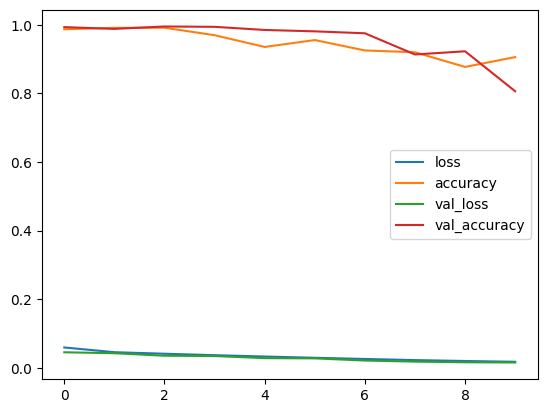

In [27]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
pd.DataFrame(hist.history).plot()
plt.show()

## Make predictions

In [28]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

res = model.predict(np.expand_dims(input_text, axis=0))

1/1 [==============================] - 1s 596ms/step


In [29]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [30]:
train_df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

## Calculating Precision and Recall

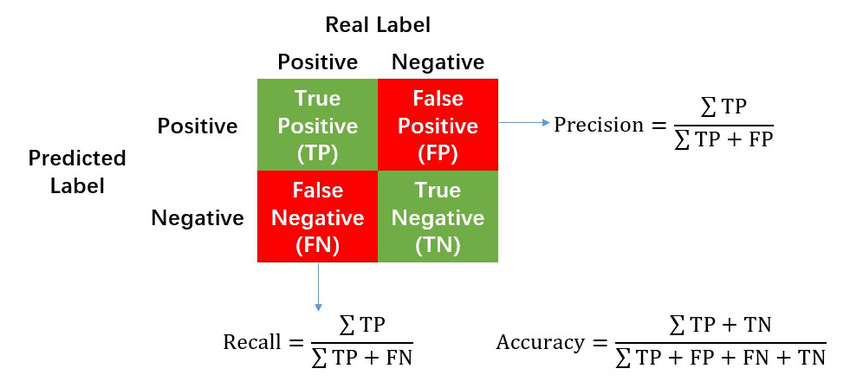

In [31]:
pre = Precision()
re = Recall()

In [32]:
for batch in test.as_numpy_iterator():
    # unpack the batch
    X_test, y_test = batch
    # make a prediction
    y_pred = model.predict(X_test)
    
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()
    
    pre.update_state(y_test, y_pred)
    re.update_state(y_test, y_pred)

1/1 [==============================] - 0s 28ms/step


In [33]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}')


Precision: 0.9598582983016968, Recall:0.8904709815979004


In [ ]:
model.save('toxicity.h5')

In [ ]:
# Cell: Load & Test Saved Model

from tensorflow.keras.models import load_model
import numpy as np

# 1) Load your model
model = load_model('toxicity.h5')

# 2) Define your helper (reuse your clean_text & LABELS)
LABELS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

def score_comment(text, threshold=0.5):
    vect    = vectorizer([text])          # shape (1, seq_len)
    probs   = model.predict(vect)[0]         # shape (6,)
    
    # Print results
    for label, p in zip(LABELS, probs):
        print(f"{label:15s} → prob {p:.3f}  → {'YES' if p>threshold else 'no'}")
    print()

# 3) Test on some examples
examples = [
    "I love this! You are awesome.",
    "You freaking suck! I'm going to hit you.",
    "I will kill you, you piece of trash."
]

for ex in examples:
    print("Input:", ex)
    score_comment(ex)


Input: I love this! You are awesome.
1/1 [==============================] - 1s 571ms/step
toxic           → prob 0.000  → no
severe_toxic    → prob 0.000  → no
obscene         → prob 0.000  → no
threat          → prob 0.000  → no
insult          → prob 0.000  → no
identity_hate   → prob 0.000  → no

Input: You freaking suck! I'm going to hit you.
1/1 [==============================] - 0s 23ms/step
toxic           → prob 0.994  → YES
severe_toxic    → prob 0.164  → no
obscene         → prob 0.867  → YES
threat          → prob 0.006  → no
insult          → prob 0.887  → YES
identity_hate   → prob 0.055  → no

Input: I will kill you, you piece of trash.
1/1 [==============================] - 0s 23ms/step
toxic           → prob 0.996  → YES
severe_toxic    → prob 0.101  → no
obscene         → prob 0.048  → no
threat          → prob 0.512  → YES
insult          → prob 0.138  → no
identity_hate   → prob 0.005  → no



In [ ]:
# Instead of model.save("toxicity.h5"):
model.save("toxicity")  